In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from collections import OrderedDict


import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import googlenet, vgg16, efficientnet_b0, resnet50
from torchvision.models import GoogLeNet_Weights, VGG16_Weights, ResNet50_Weights, EfficientNet_B0_Weights
from torchsummary import summary
from torch import optim

# Parameters Setting

In [ ]:
root = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(2)/fire_ds"
train_path = os.path.join(root, "train")
val_path = os.path.join(root, "val")
test_path = os.path.join(root, "test")

epochs = 20
batch_size = 32
learning_rate = 0.01


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


# Dataset

## customized dataset

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# training data
train_ds = ImageFolder(train_path, transform=train_transforms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# validation data
val_ds = ImageFolder(val_path, transform=train_transforms)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

# testing data
test_ds = ImageFolder(test_path, transform=test_transforms)
test_dl = DataLoader(test_ds, batch_size=batch_size)

dataloader = {"train":train_dl, "val":val_dl}


## observe dataset

In [ ]:
train_size, val_size, test_size = len(train_ds), len(val_ds), len(test_ds)
total = train_size + val_size + test_size

train_lbl_0, train_lbl_1 = 0, 0
val_lbl_0, val_lbl_1 = 0, 0
test_lbl_0, test_lbl_1 = 0, 0

# training set
for i in range(0, train_size):
  if train_ds[i][1] == 0:
    train_lbl_0 += 1
  else:
    train_lbl_1 += 1

# validation set
for i in range(0, val_size):
  if val_ds[i][1] == 0:
    val_lbl_0 += 1
  else:
    val_lbl_1 += 1

# test set
for i in range(0, test_size):
  if test_ds[i][1] == 0:
    test_lbl_0 += 1
  else:
    test_lbl_1 += 1

neutral_col = [train_lbl_0, val_lbl_0, test_lbl_0]
fire_col = [train_lbl_1, val_lbl_1, test_lbl_1]
imbalanced_col = [f"{(train_lbl_0/train_lbl_1):.2f}", f"{(val_lbl_0/val_lbl_1):.2f}", f"{(test_lbl_0/test_lbl_1):.2f}"]
ratio_col = [f"{(train_size/total):.1f}", f"{(val_size/total):.1f}", f"{(test_size/total):.1f}"]

ds_form = pd.DataFrame({"neutral(label 0)":neutral_col,
             "fire(label 1)":fire_col,
             "imbalanced":imbalanced_col,
             "ratio":ratio_col}, index=["train", "val", "test"])
ds_form


,neutral(label 0),fire(label 1),imbalanced,ratio
train,1370,1429,0.96,0.7
val,152,159,0.96,0.1
test,381,397,0.96,0.2


# Observe Proposed Model

## GoogLeNet

In [ ]:
# download model and observe architecture
google = googlenet(GoogLeNet_Weights.DEFAULT)
google.fc = nn.Linear(1024, 1)

#for name, layer in google.named_children():
#  print(name)
#  print(layer)

#summary(google.to(device), input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 33.2MB/s]


In [ ]:
# freeze parameters before classifier
for name, param in google.named_parameters():
  if name.startswith("fc"):
    continue
  else:
    param.requires_grad = False

## VGG-16

In [ ]:
# download model and observe architecture
vgg = vgg16(VGG16_Weights.DEFAULT)
vgg.classifier[-1] = nn.Linear(4096, 1)

#for name, layer in vgg.named_children():
#  print(name)
#  print(layer)

#summary(vgg.to(device), input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 97.5MB/s]


In [ ]:
# freeze parameters before classifier
for name, param in vgg.named_parameters():
  if name.startswith("classifier"):
    continue
  else:
    param.requires_grad = False

## ResNet-50

In [ ]:
# download model and observe architecture
res = resnet50(ResNet50_Weights.DEFAULT)
res.fc = nn.Linear(2048, 1)

#for name, layer in res.named_children():
#  print(name)
#  print(layer)

#summary(res.to(device), input_size=(3, 224, 224))

In [ ]:
# freeze parameters before classifier
for name, param in res.named_parameters():
  if name.startswith("fc"):
    continue
  else:
    param.requires_grad = False

## EfficientNet_B0

In [ ]:
# download model and observe architecture
effi = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)
effi.classifier[-1] = nn.Linear(1280, 1)

#for name, layer in effi.named_children():
#  print(name)
#  print(layer)

#summary(effi.to(device), input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 55.3MB/s]


In [ ]:
# freeze parameters before classifier
for name, param in effi.named_parameters():
  if name.startswith("classifier"):
    continue
  else:
    param.requires_grad = False

# Modify Model Architecture
we can observe that all proposed model have AdaptiveAvgPool2d before fully connected layer, but their output size are different, so we can use this architecture to customized these model as same as proposed model in paper.On the other hand, because all model architecture is too long, we only show mpdified VGG-16, other models are like it.

## attention layer

In [ ]:
class Attention_Layer(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.query_weight = nn.Linear(in_features, out_features, bias=False)
    self.key_weight = nn.Linear(in_features, out_features, bias=False)
    self.value_weight = nn.Linear(in_features, out_features, bias=False)
    #self.softmax = nn.Softmax(dim=-1)
    self.ReLU = nn.ReLU(inplace=True)
    self.out_projection = nn.Linear(out_features, out_features)

  def forward(self, x):
    query = self.query_weight(x)
    key = self.key_weight(x)
    value = self.value_weight(x)

    attention_score = torch.matmul(key.t(), query)
    #attention_score = self.softmax(attention_score)
    attention_score = self.ReLU(attention_score)
    attention_value = torch.matmul(value, attention_score)
    output = self.out_projection(attention_value)
    return output

## define model architecture

In [ ]:
class Modifiedmodel(nn.Module):
  def __init__(self, model, add_layer):
    super().__init__()
    self.model = copy.deepcopy(model)
    self.add_layer = add_layer
    self.layer_list = []

    # freeze all parameters
    for param in self.model.parameters():
      param.requires_grad = False

    # modify model
    for name, layer in self.model.named_children():
      if name == "avgpool":
        break
      else:
        self.layer_list.append(layer)

    self.features = nn.Sequential(*self.layer_list)
    self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.classifier = nn.Sequential(*self.add_layer)
    self.model = None

  def forward(self, x):
    x = self.features(x)
    x = self.gap(x)
    output = self.classifier(x)

    return output


# Construct Proposed Model

## GoogLeNet

In [ ]:
add_layer_google = [
    nn.BatchNorm2d(num_features=1024, momentum=0.99),
    nn.Flatten(),
    nn.Linear(1024, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    Attention_Layer(32, 250),
    nn.Linear(250, 1),
    nn.Sigmoid()
    ]

google_atten = Modifiedmodel(model=google, add_layer=add_layer_google)

# observe modified architecture
#summary(google_atten.to(device), input_size=(3, 224, 224))

## VGG-16

In [ ]:
add_layer_vgg = [
    nn.BatchNorm2d(num_features=512, momentum=0.99),
    nn.Flatten(),
    nn.Linear(512, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    Attention_Layer(32, 250),
    nn.Linear(250, 1),
    nn.Sigmoid()
    ]

vgg_atten = Modifiedmodel(model=vgg, add_layer=add_layer_vgg)

# observe modified architecture
#summary(vgg_atten, input_size=(3, 224, 224))
#for name, layer in vgg_atten.named_children():
#  print(name)
#  print(layer)

## ResNet-50

In [ ]:
add_layer_res = [
    nn.BatchNorm2d(num_features=2048, momentum=0.99),
    nn.Flatten(),
    nn.Linear(2048, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    Attention_Layer(32, 250),
    nn.Linear(250, 1),
    nn.Sigmoid()
    ]

res_atten = Modifiedmodel(model=res, add_layer=add_layer_res)

# observe modified architecture
#summary(res_atten, input_size=(3, 224, 224))

## EfficientNet_B0

In [ ]:
add_layer_effi = [
    nn.BatchNorm2d(num_features=1280, momentum=0.99),
    nn.Flatten(),
    nn.Linear(1280, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(32, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    Attention_Layer(32, 250),
    nn.Linear(250, 1),
    nn.Sigmoid()
    ]

effi_atten = Modifiedmodel(model=effi, add_layer=add_layer_effi)

# observe modified architecture
#summary(effi_atten, input_size=(3, 224, 224))

# Training for Original Model

## define training function

In [ ]:
def train_without_attention(model, criterion, optimizer, epochs):
  since = time.time()
  sigmoid = nn.Sigmoid()

  best_model_parameters = copy.deepcopy(model.state_dict())
  best_loss = float("inf")
  loss_list = []
  acc_list = []
  threshold = torch.tensor(0.5)

  for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch}/{epochs}")
    print("-" * 15)

    batch_loss = 0.0
    corrects = 0

    for data, label in dataloader["train"]:
      data, label = data.to(device), label.to(device)
      label = torch.unsqueeze(label, dim=1)
      label = label.float()

      optimizer.zero_grad()

      output = model(data)
      output = sigmoid(output)

      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

      # loss and correct
      batch_loss += loss.item() * data.size(0)
      pred = output > threshold
      corrects += torch.sum(pred == label.data)

    epoch_loss = batch_loss / len(dataloader["train"].dataset)
    epoch_acc = corrects / len(dataloader["train"].dataset)
    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc.item())
    print(f"Loss: {epoch_loss:.5f}")
    print(f"Acc: {epoch_acc:.5f}")
    print()

    # save best model
    if epoch_loss < best_loss:
      best_loss = epoch_loss
      best_model_parameters = copy.deepcopy(model.state_dict())

  # save model
  times = time.time() - since
  print(f"Train Complete !")
  print(f"time: {times//60} min {(times%60):.0f} sec")
  model.load_state_dict(best_model_parameters)

  return model, loss_list, acc_list


In [ ]:
# loss function
criterion = nn.BCELoss()

## GoogLeNet

In [ ]:
# google net
google = google.to(device)
optim_google = optim.Adagrad(google.parameters(), lr=learning_rate, weight_decay=0.1)
google, google_loss, google_acc = train_without_attention(google, criterion, optim_google, epochs)


In [ ]:
print(google_loss)
print(google_acc)

[0.3906853222003704, 0.26716710382719133, 0.24698639348836063, 0.2360722799787099, 0.2277281189782571, 0.22971334828249512, 0.2194057298733022, 0.22027626018219226, 0.21684767673721736, 0.22557110091050467, 0.2109836520638454, 0.21258341858283925, 0.21171804952723675, 0.211356054881016, 0.21193753822802133, 0.2224056503631337, 0.21048743119939134, 0.2157907510184952, 0.21358793222742364, 0.2090432977263269]
[tensor(0.8835, device='cuda:0'), tensor(0.9353, device='cuda:0'), tensor(0.9353, device='cuda:0'), tensor(0.9407, device='cuda:0'), tensor(0.9461, device='cuda:0'), tensor(0.9389, device='cuda:0'), tensor(0.9478, device='cuda:0'), tensor(0.9457, device='cuda:0'), tensor(0.9482, device='cuda:0'), tensor(0.9418, device='cuda:0'), tensor(0.9561, device='cuda:0'), tensor(0.9525, device='cuda:0'), tensor(0.9525, device='cuda:0'), tensor(0.9507, device='cuda:0'), tensor(0.9518, device='cuda:0'), tensor(0.9403, device='cuda:0'), tensor(0.9518, device='cuda:0'), tensor(0.9482, device='cuda

In [ ]:
google_loss = [0.3906853222003704, 0.26716710382719133, 0.24698639348836063, 0.2360722799787099, 0.2277281189782571, 0.22971334828249512, 0.2194057298733022, 0.22027626018219226, 0.21684767673721736, 0.22557110091050467, 0.2109836520638454, 0.21258341858283925, 0.21171804952723675, 0.211356054881016, 0.21193753822802133, 0.2224056503631337, 0.21048743119939134, 0.2157907510184952, 0.21358793222742364, 0.2090432977263269]
google_acc = [0.8835, 0.9353, 0.9353, 0.8407, 0.9461, 0.9389, 0.9478, 0.9457, 0.9482, 0.9418, 0.9561, 0.9525, 0.9525, 0.9507, 0.9518, 0.9403, 0.9518, 0.9482, 0.9503, 0.9478]

## VGG-16

In [ ]:
# vgg-16
vgg = vgg.to(device)
optim_vgg = optim.Adagrad(vgg.parameters(), lr=learning_rate, weight_decay=0.1)
vgg, vgg_loss, vgg_acc = train_without_attention(vgg, criterion, optim_vgg, epochs)


Epoch: 1/20
---------------
Loss: 7.09403
Acc: 0.74455

Epoch: 2/20
---------------
Loss: 0.17498
Acc: 0.93712

Epoch: 3/20
---------------
Loss: 0.13952
Acc: 0.96034

Epoch: 4/20
---------------
Loss: 0.11334
Acc: 0.96392

Epoch: 5/20
---------------
Loss: 0.10547
Acc: 0.96927

Epoch: 6/20
---------------
Loss: 0.10804
Acc: 0.96356

Epoch: 7/20
---------------
Loss: 0.09913
Acc: 0.97035

Epoch: 8/20
---------------
Loss: 0.10594
Acc: 0.96999

Epoch: 9/20
---------------
Loss: 0.10741
Acc: 0.96999

Epoch: 10/20
---------------
Loss: 0.08832
Acc: 0.97463

Epoch: 11/20
---------------
Loss: 0.09775
Acc: 0.96677

Epoch: 12/20
---------------
Loss: 0.08574
Acc: 0.97499

Epoch: 13/20
---------------
Loss: 0.08287
Acc: 0.97749

Epoch: 14/20
---------------
Loss: 0.07279
Acc: 0.98214

Epoch: 15/20
---------------
Loss: 0.07528
Acc: 0.97964

Epoch: 16/20
---------------
Loss: 0.08322
Acc: 0.97821

Epoch: 17/20
---------------
Loss: 0.07629
Acc: 0.97964

Epoch: 18/20
---------------
Loss: 0.071

In [ ]:
print(vgg_loss)
print(vgg_acc)

[7.094032052698072, 0.17497940775687118, 0.1395235536709859, 0.11334281868064093, 0.10547363032460766, 0.10803955009725529, 0.09913015203359468, 0.10593751879430915, 0.10741309871648881, 0.08831604347351663, 0.09775428591604189, 0.08574285362183345, 0.08286907368683312, 0.07279356854537548, 0.07527559807190685, 0.08321971202714394, 0.07629471225647383, 0.0715673295631286, 0.064691058431578, 0.07352631676725167]
[tensor(0.7446, device='cuda:0'), tensor(0.9371, device='cuda:0'), tensor(0.9603, device='cuda:0'), tensor(0.9639, device='cuda:0'), tensor(0.9693, device='cuda:0'), tensor(0.9636, device='cuda:0'), tensor(0.9703, device='cuda:0'), tensor(0.9700, device='cuda:0'), tensor(0.9700, device='cuda:0'), tensor(0.9746, device='cuda:0'), tensor(0.9668, device='cuda:0'), tensor(0.9750, device='cuda:0'), tensor(0.9775, device='cuda:0'), tensor(0.9821, device='cuda:0'), tensor(0.9796, device='cuda:0'), tensor(0.9782, device='cuda:0'), tensor(0.9796, device='cuda:0'), tensor(0.9839, device='

In [ ]:
vgg_loss = [7.094032052698072, 0.17497940775687118, 0.1395235536709859, 0.11334281868064093, 0.10547363032460766, 0.10803955009725529, 0.09913015203359468, 0.10593751879430915, 0.10741309871648881, 0.08831604347351663, 0.09775428591604189, 0.08574285362183345, 0.08286907368683312, 0.07279356854537548, 0.07527559807190685, 0.08321971202714394, 0.07629471225647383, 0.0715673295631286, 0.064691058431578, 0.07352631676725167]
vgg_acc = [0.7446, 0.9371, 0.9603, 0.9639, 0.9693, 0.9636, 0.9703, 0.9700, 0.9700, 0.9746, 0.9668, 0.9750, 0.9775, 0.9821, 0.9796, 0.9782, 0.9796, 0.9839, 0.9857, 0.9814]

## ResNet-50

In [ ]:
# resnet-50
res = res.to(device)
optim_res = optim.Adagrad(res.parameters(), lr=learning_rate, weight_decay=0.1)
res, res_loss, res_acc = train_without_attention(res, criterion, optim_res, epochs)


Epoch: 1/20
---------------
Loss: 0.26090
Acc: 0.92819

Epoch: 2/20
---------------
Loss: 0.19427
Acc: 0.96284

Epoch: 3/20
---------------
Loss: 0.18485
Acc: 0.96785

Epoch: 4/20
---------------
Loss: 0.18184
Acc: 0.96499

Epoch: 5/20
---------------
Loss: 0.18198
Acc: 0.96320

Epoch: 6/20
---------------
Loss: 0.18434
Acc: 0.96749

Epoch: 7/20
---------------
Loss: 0.18025
Acc: 0.96713

Epoch: 8/20
---------------
Loss: 0.17369
Acc: 0.96713

Epoch: 9/20
---------------
Loss: 0.17184
Acc: 0.97070

Epoch: 10/20
---------------
Loss: 0.17942
Acc: 0.96785

Epoch: 11/20
---------------
Loss: 0.17494
Acc: 0.96963

Epoch: 12/20
---------------
Loss: 0.17595
Acc: 0.97035

Epoch: 13/20
---------------
Loss: 0.18091
Acc: 0.96749

Epoch: 14/20
---------------
Loss: 0.17855
Acc: 0.96785

Epoch: 15/20
---------------
Loss: 0.17869
Acc: 0.96785

Epoch: 16/20
---------------
Loss: 0.17784
Acc: 0.96713

Epoch: 17/20
---------------
Loss: 0.17696
Acc: 0.96999

Epoch: 18/20
---------------
Loss: 0.182

In [ ]:
res_loss = [0.26090, 0.19427, 0.18485, 0.18184, 0.18198, 0.18434, 0.18025, 0.17369, 0.17184, 0.17942, 0.17494, 0.17595, 0.18091, 0.17855, 0.17869, 0.17784, 0.17696, 0.18214, 0.17929, 0.17530]

## EfficientNet_B0

In [ ]:
# efficientnet_b0
effi = effi.to(device)
optim_effi = optim.Adagrad(effi.parameters(), lr=learning_rate, weight_decay=0.1)
effi, effi_loss, effi_acc = train_without_attention(effi, criterion, optim_effi, epochs)

Epoch: 1/20
---------------
Loss: 0.29368
Acc: 0.92140

Epoch: 2/20
---------------
Loss: 0.22378
Acc: 0.94534

Epoch: 3/20
---------------
Loss: 0.20785
Acc: 0.95498

Epoch: 4/20
---------------
Loss: 0.20625
Acc: 0.95284

Epoch: 5/20
---------------
Loss: 0.19607
Acc: 0.95105

Epoch: 6/20
---------------
Loss: 0.19981
Acc: 0.95105

Epoch: 7/20
---------------
Loss: 0.19816
Acc: 0.95320

Epoch: 8/20
---------------
Loss: 0.19667
Acc: 0.95713

Epoch: 9/20
---------------
Loss: 0.20034
Acc: 0.95463

Epoch: 10/20
---------------
Loss: 0.20430
Acc: 0.95034

Epoch: 11/20
---------------
Loss: 0.20319
Acc: 0.95391

Epoch: 12/20
---------------
Loss: 0.19936
Acc: 0.95141

Epoch: 13/20
---------------
Loss: 0.20562
Acc: 0.94927

Epoch: 14/20
---------------
Loss: 0.19816
Acc: 0.95606

Epoch: 15/20
---------------
Loss: 0.19571
Acc: 0.95677

Epoch: 16/20
---------------
Loss: 0.19699
Acc: 0.95284

Epoch: 17/20
---------------
Loss: 0.19549
Acc: 0.95999

Epoch: 18/20
---------------
Loss: 0.198

In [ ]:
effi_loss = [0.29368, 0.22378, 0.20785, 0.20625, 0.19607, 0.19981, 0.19816, 0.19667, 0.20034, 0.20430, 0.20319, 0.19936, 0.20562, 0.19816, 0.19571, 0.19699, 0.19549, 0.19815, 0.20400, 0.19835]

## visualize loss function

In [ ]:
def visualize_loss(loss_acc, title, num=0):
  for i in range(2):   # control row
    for j in range(2): # control column
      ax = plt.subplot(2, 2, num+1)
      ax.plot(range(1, epochs+1), loss_acc[num])
      ax.set_xlabel("epochs")
      ax.set_title(title[num])
      num += 1
  plt.tight_layout()
  plt.show()

# since data type of acc is torch.tensor on "cuda"
# we must convert it into "cpu"
def cuda_to_cpu(tensor_list):
  tensor_to_float = [tensor.cpu().item() for tensor in tensor_list]
  return tensor_to_float

google_acc = cuda_to_cpu(google_acc)
vgg_acc = cuda_to_cpu(vgg_acc)
res_acc = cuda_to_cpu(res_acc)
effi_acc = cuda_to_cpu(effi_acc)

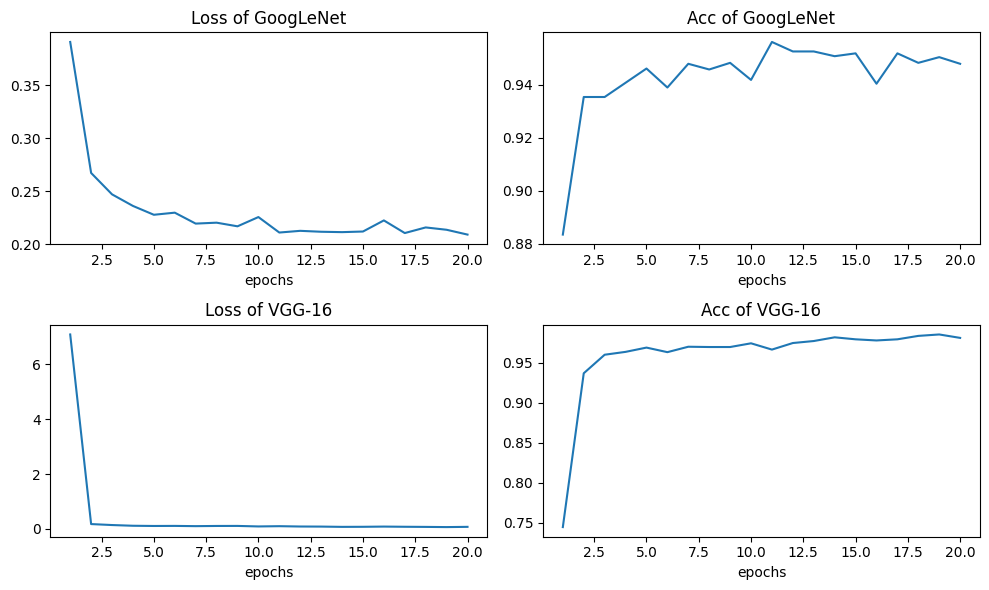

In [ ]:
loss_acc_1 = [google_loss, google_acc, vgg_loss, vgg_acc]
title_1 = ["Loss of GoogLeNet", "Acc of GoogLeNet", "Loss of VGG-16", "Acc of VGG-16"]

plt.figure(figsize=(10, 6))
visualize_loss(loss_acc_1, title_1)


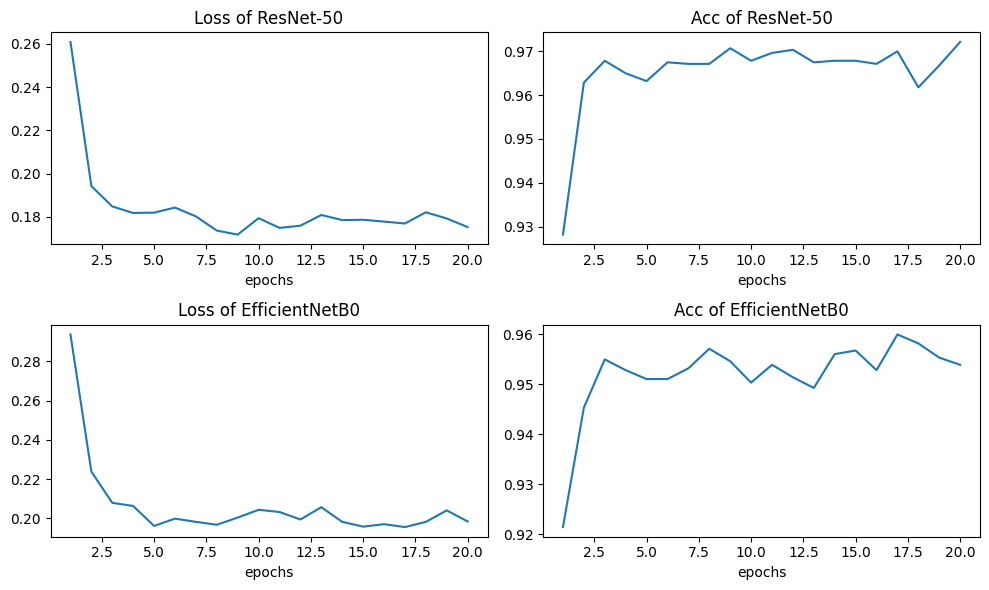

In [ ]:
loss_acc_2 = [res_loss, res_acc, effi_loss, effi_acc]
title_2 = ["Loss of ResNet-50", "Acc of ResNet-50", "Loss of EfficientNetB0", "Acc of EfficientNetB0"]

plt.figure(figsize=(10, 6))
visualize_loss(loss_acc_2, title_2)

# Training for Modified Model(暫略)

## define training function

In [ ]:
def train_with_attention(model, criterion, optimizer, epochs):
  since = time.time()

  best_model_parameters = copy.deepcopy(model.state_dict())
  best_loss = float("inf")
  best_acc = (-1) * float("inf")

  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  threshold = torch.tensor(0.5)

  for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch}/{epochs}")
    print("-"*15)

    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      batch_loss = 0.0
      corrects = 0

      for data, label in dataloader[phase]:
        data, label = data.to(device), label.to(device)
        label = torch.unsqueeze(label, dim=1)
        label = label.float()

        # zero gradient
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          output = model(data)

          loss = criterion(output, label)
          pred = output > threshold

          if phase == "train":
            loss.backward() # back propagation
            optimizer.step() # update parameters

        batch_loss += loss.item() * data.size(0)
        corrects += torch.sum(pred == label.data)

      # save epoch loss and acc
      epoch_loss = batch_loss / len(dataloader[phase].dataset)
      epoch_acc = corrects / len(dataloader[phase].dataset)
      if phase == "train":
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())
      else:
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc.item())
      print(f"{phase} Loss: {epoch_loss:.5f} Acc: {epoch_acc:.5f}")

      # save model in train stage
      if (phase == "train") and (epoch_loss < best_loss):
        best_loss = epoch_loss
        best_model_parameters = copy.deepcopy(model.state_dict())

      # save best acc in val stage
      if (phase == "val") and (epoch_acc > best_acc):
        best_acc = epoch_acc

  times = time.time() - since
  print("Training Complete !")
  print(f"Best Acc in val: {best_acc}")
  print(f"time: {times//60} min {(times%60):.0f} sec")
  model.load_state_dict(best_model_parameters)

  return model, train_loss, train_acc, val_loss, val_acc


In [ ]:
criterion = nn.BCELoss()

## GoogLeNet

In [ ]:
google_atten = google_atten.to(device)
optim_google_atten = optim.Adagrad(google_atten.parameters(), lr=learning_rate, weight_decay=0.1)

google_atten, google_train_loss, google_train_acc, google_val_loss, google_val_acc = train_with_attention(google_atten, criterion=criterion,
                                                        optimizer=optim_google_atten, epochs=epochs)


Epoch: 1/20
---------------
train Loss: 0.69362 Acc: 0.48946
val Loss: 0.69331 Acc: 0.48875
Epoch: 2/20
---------------
train Loss: 0.69326 Acc: 0.48946
val Loss: 0.69318 Acc: 0.48875
Epoch: 3/20
---------------
train Loss: 0.69317 Acc: 0.50125
val Loss: 0.69310 Acc: 0.51125
Epoch: 4/20
---------------
train Loss: 0.69311 Acc: 0.50697
val Loss: 0.69306 Acc: 0.51125
Epoch: 5/20
---------------
train Loss: 0.69307 Acc: 0.51054
val Loss: 0.69304 Acc: 0.51125
Epoch: 6/20
---------------
train Loss: 0.69305 Acc: 0.51054
val Loss: 0.69302 Acc: 0.51125
Epoch: 7/20
---------------
train Loss: 0.69304 Acc: 0.51054
val Loss: 0.69301 Acc: 0.51125
Epoch: 8/20
---------------
train Loss: 0.69303 Acc: 0.51054
val Loss: 0.69299 Acc: 0.51125
Epoch: 9/20
---------------
train Loss: 0.69301 Acc: 0.51054
val Loss: 0.69298 Acc: 0.51125
Epoch: 10/20
---------------
train Loss: 0.69300 Acc: 0.51054
val Loss: 0.69298 Acc: 0.51125
Epoch: 11/20
---------------
train Loss: 0.69300 Acc: 0.51054
val Loss: 0.69297

In [ ]:
# 避免萬一先存
print(google_train_loss)
print(google_train_acc)
print(google_val_loss)
print(google_val_acc)

[0.6936209814895175, 0.6932637202778047, 0.6931686724199061, 0.6931097303683863, 0.6930705609173381, 0.6930532139426855, 0.6930413132013701, 0.6930298399141577, 0.693013195716385, 0.6930047070694719, 0.6930013968076566, 0.6929940432043917, 0.6929898727745105, 0.69298481589856, 0.6929797068712071, 0.6929794003938768, 0.6929736001102275, 0.6929730845800933, 0.6929717864595, 0.6929683209147015]
[tensor(0.4895, device='cuda:0'), tensor(0.4895, device='cuda:0'), tensor(0.5013, device='cuda:0'), tensor(0.5070, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5

## VGG-16

In [ ]:
vgg_atten = vgg_atten.to(device)
optim_vgg_atten = optim.Adagrad(vgg_atten.parameters(), lr=learning_rate, weight_decay=0.1)

vgg_atten, vgg_train_loss, vgg_train_acc, vgg_val_loss, vgg_val_acc = train_with_attention(vgg_atten, criterion=criterion, optimizer=optim_vgg_atten,
                                                 epochs=epochs)


Epoch: 1/20
---------------
train Loss: 0.69326 Acc: 0.50304
val Loss: 0.69299 Acc: 0.51125
Epoch: 2/20
---------------
train Loss: 0.69302 Acc: 0.51054
val Loss: 0.69297 Acc: 0.51125
Epoch: 3/20
---------------
train Loss: 0.69301 Acc: 0.51054
val Loss: 0.69296 Acc: 0.51125
Epoch: 4/20
---------------
train Loss: 0.69300 Acc: 0.51054
val Loss: 0.69295 Acc: 0.51125
Epoch: 5/20
---------------
train Loss: 0.69299 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 6/20
---------------
train Loss: 0.69298 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 7/20
---------------
train Loss: 0.69298 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 8/20
---------------
train Loss: 0.69297 Acc: 0.51054
val Loss: 0.69293 Acc: 0.51125
Epoch: 9/20
---------------
train Loss: 0.69297 Acc: 0.51054
val Loss: 0.69293 Acc: 0.51125
Epoch: 10/20
---------------
train Loss: 0.69296 Acc: 0.51054
val Loss: 0.69293 Acc: 0.51125
Epoch: 11/20
---------------
train Loss: 0.69297 Acc: 0.51054
val Loss: 0.69293

In [ ]:
# 避免萬一先存
print(vgg_train_loss)
print(vgg_train_acc)
print(vgg_val_loss)
print(vgg_val_acc)

[0.6932578958669446, 0.6930197553576721, 0.6930096183090646, 0.6929966443434236, 0.692989255709919, 0.6929754207882979, 0.6929755163388663, 0.6929695811515282, 0.6929711011657974, 0.692962383278441, 0.6929657441371251, 0.6929677774455557, 0.6929595542831394, 0.6929600106558232, 0.6929618229436721, 0.6929635114225161, 0.692960217728194, 0.6929554118135649, 0.6929558876285642, 0.6929560870560376]
[tensor(0.5030, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(

## ResNet-50

In [ ]:
res_atten = res_atten.to(device)
optim_res_atten = optim.Adagrad(res_atten.parameters(), lr=learning_rate, weight_decay=0.1)

res_atten, res_train_loss, res_train_acc, res_val_loss, res_val_acc = train_with_attention(res_atten, criterion=criterion, optimizer=optim_res_atten,
                                                 epochs=epochs)


Epoch: 1/20
---------------
train Loss: 0.69332 Acc: 0.50339
val Loss: 0.69300 Acc: 0.51125
Epoch: 2/20
---------------
train Loss: 0.69303 Acc: 0.51054
val Loss: 0.69297 Acc: 0.51125
Epoch: 3/20
---------------
train Loss: 0.69301 Acc: 0.51054
val Loss: 0.69296 Acc: 0.51125
Epoch: 4/20
---------------
train Loss: 0.69299 Acc: 0.51054
val Loss: 0.69295 Acc: 0.51125
Epoch: 5/20
---------------
train Loss: 0.69299 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 6/20
---------------
train Loss: 0.69298 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 7/20
---------------
train Loss: 0.69298 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 8/20
---------------
train Loss: 0.69297 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 9/20
---------------
train Loss: 0.69297 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 10/20
---------------
train Loss: 0.69296 Acc: 0.51054
val Loss: 0.69294 Acc: 0.51125
Epoch: 11/20
---------------
train Loss: 0.69297 Acc: 0.51054
val Loss: 0.69294

In [ ]:
# 避免萬一先存
print(res_train_loss)
print(res_train_acc)
print(res_val_loss)
print(res_val_acc)

[0.6933240913075607, 0.6930256369455493, 0.6930058767387551, 0.6929926808155533, 0.6929860908289218, 0.6929824751119351, 0.6929794822517741, 0.692972263403133, 0.6929678114323413, 0.6929613335637715, 0.6929679096234871, 0.6929677768705913, 0.6929722762014151, 0.692965470092047, 0.6929660612406497, 0.6929575740417953, 0.6929629729363952, 0.692960122688705, 0.6929605204363132, 0.692965384039039]
[tensor(0.5034, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0

## EfficientNet_B0

In [ ]:
effi_atten = effi_atten.to(device)
optim_effi_atten = optim.Adagrad(effi_atten.parameters(), lr=learning_rate, weight_decay=0.1)

effi_atten, effi_train_loss, effi_train_acc, effi_val_loss, effi_val_acc = train_with_attention(effi_atten, criterion=criterion, optimizer=optim_effi_atten,
                                                   epochs=epochs)


Epoch: 1/20
---------------
train Loss: 0.69334 Acc: 0.50697
val Loss: 0.69305 Acc: 0.51125
Epoch: 2/20
---------------
train Loss: 0.69307 Acc: 0.51054
val Loss: 0.69301 Acc: 0.51125
Epoch: 3/20
---------------
train Loss: 0.69304 Acc: 0.51054
val Loss: 0.69299 Acc: 0.51125
Epoch: 4/20
---------------
train Loss: 0.69302 Acc: 0.51054
val Loss: 0.69297 Acc: 0.51125
Epoch: 5/20
---------------
train Loss: 0.69301 Acc: 0.51054
val Loss: 0.69296 Acc: 0.51125
Epoch: 6/20
---------------
train Loss: 0.69299 Acc: 0.51054
val Loss: 0.69296 Acc: 0.51125
Epoch: 7/20
---------------
train Loss: 0.69299 Acc: 0.51054
val Loss: 0.69295 Acc: 0.51125
Epoch: 8/20
---------------
train Loss: 0.69298 Acc: 0.51054
val Loss: 0.69295 Acc: 0.51125
Epoch: 9/20
---------------
train Loss: 0.69298 Acc: 0.51054
val Loss: 0.69295 Acc: 0.51125
Epoch: 10/20
---------------
train Loss: 0.69297 Acc: 0.51054
val Loss: 0.69295 Acc: 0.51125
Epoch: 11/20
---------------
train Loss: 0.69298 Acc: 0.51054
val Loss: 0.69294

In [ ]:
# 避免萬一先存
print(effi_train_loss)
print(effi_train_acc)
print(effi_val_loss)
print(effi_val_acc)

[0.6933360600224475, 0.6930709117946986, 0.6930395422257795, 0.6930180536333516, 0.6930059973961031, 0.6929916254790096, 0.6929897282454915, 0.692981832961859, 0.6929772300948497, 0.6929723398308109, 0.6929843921284882, 0.6929701881222999, 0.692970769028018, 0.6929725081037308, 0.6929655842118367, 0.692964239859845, 0.6929589451828698, 0.69296495245371, 0.6929605768254162, 0.6929581811616318]
[tensor(0.5070, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.5105, device='cuda:0'), tensor(0.

## visualize loss function

In [ ]:
def visualize(model_name, loss_acc, title):
  index = 0
  plt.figure(figsize=((10, 6)))
  for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax.plot(range(1, epochs+1), loss_acc[index], label="train")
    index += 1
    ax.plot(range(1, epochs+1), loss_acc[index], label="vall")
    index += 1
    ax.set_xlabel("epochs")
    ax.set_title(title[i])

  plt.suptitle(model_name)
  plt.show()

# since data type of acc is torch.tensor on "cuda"
# we must convert it into float on "cpu"
def cuda_to_cpu(tensor_list):
  tensor_to_float = [tensor.cpu().item() for tensor in tensor_list]
  return tensor_to_float


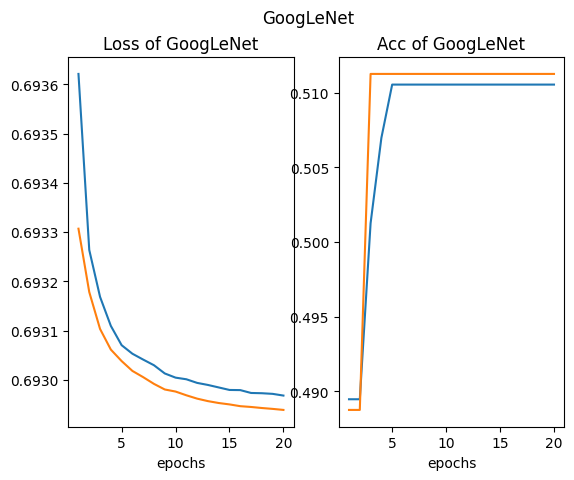

In [ ]:
# googlenet
google_train_acc = cuda_to_cpu(google_train_acc)
google_val_acc = cuda_to_cpu(google_val_acc)

loss_acc_google = [google_train_loss, google_val_loss, google_train_acc, google_val_acc]
title_google = ["Loss of GoogLeNet", "Acc of GoogLeNet"]

visualize("GoogLeNet", loss_acc_google, title_google)



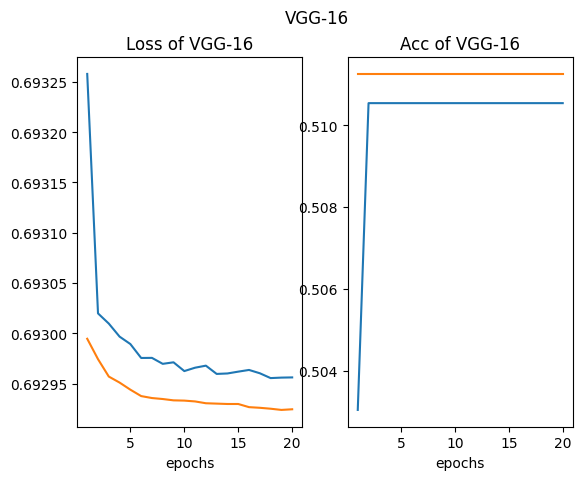

In [ ]:
# vgg-16
vgg_train_acc = cuda_to_cpu(vgg_train_acc)
vgg_val_acc = cuda_to_cpu(vgg_val_acc)

loss_acc_vgg = [vgg_train_loss, vgg_val_loss, vgg_train_acc, vgg_val_acc]
title_vgg = ["Loss of VGG-16", "Acc of VGG-16"]

visualize("VGG-16", loss_acc_vgg, title_vgg)



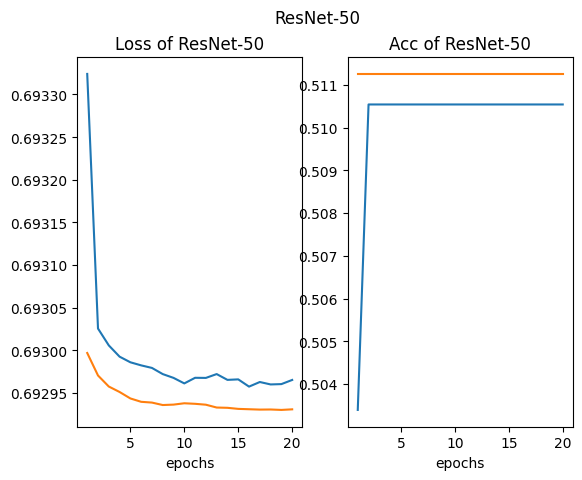

In [ ]:
# resnet
res_train_acc = cuda_to_cpu(res_train_acc)
res_val_acc = cuda_to_cpu(res_val_acc)

loss_acc_res = [res_train_loss, res_val_loss, res_train_acc, res_val_acc]
title_res = ["Loss of ResNet-50", "Acc of ResNet-50"]

visualize("ResNet-50", loss_acc_res, title_res)



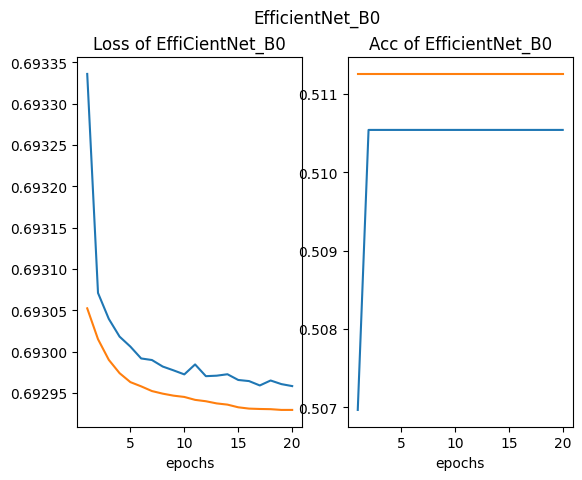

In [ ]:
# efficientnet
effi_train_acc = cuda_to_cpu(effi_train_acc)
effi_val_acc = cuda_to_cpu(effi_val_acc)

loss_acc_effi = [effi_train_loss, effi_val_loss, effi_train_acc, effi_val_acc]
title_effi = ["Loss of EffiCientNet_B0", "Acc of EfficientNet_B0"]

visualize("EfficientNet_B0", loss_acc_effi, title_effi)



# Training for Modified Model(relu)

## define training function

In [ ]:
def train_with_attention(model, criterion, optimizer, epochs):
  since = time.time()

  best_model_parameters = copy.deepcopy(model.state_dict())
  best_loss = float("inf")
  best_acc = (-1) * float("inf")

  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  threshold = torch.tensor(0.5)

  for epoch in range(1, epochs+1):
    print(f"Epoch: {epoch}/{epochs}")
    print("-"*15)

    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      batch_loss = 0.0
      corrects = 0

      for data, label in dataloader[phase]:
        data, label = data.to(device), label.to(device)
        label = torch.unsqueeze(label, dim=1)
        label = label.float()

        # zero gradient
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          output = model(data)

          loss = criterion(output, label)
          pred = output > threshold

          if phase == "train":
            loss.backward() # back propagation
            optimizer.step() # update parameters

        batch_loss += loss.item() * data.size(0)
        corrects += torch.sum(pred == label.data)

      # save epoch loss and acc
      epoch_loss = batch_loss / len(dataloader[phase].dataset)
      epoch_acc = corrects / len(dataloader[phase].dataset)
      if phase == "train":
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())
      else:
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc.item())
      print(f"{phase} Loss: {epoch_loss:.5f} Acc: {epoch_acc:.5f}")

      # save model in train stage
      if (phase == "train") and (epoch_loss < best_loss):
        best_loss = epoch_loss
        #best_model_parameters = copy.deepcopy(model.state_dict())

      # save best acc in val stage
      if (phase == "val") and (epoch_acc > best_acc):
        best_acc = epoch_acc
        best_model_parameters = copy.deepcopy(model.state_dict())

  times = time.time() - since
  print("Training Complete !")
  print(f"Best Acc in val: {best_acc}")
  print(f"time: {times//60} min {(times%60):.0f} sec")
  model.load_state_dict(best_model_parameters)

  return model, train_loss, train_acc, val_loss, val_acc


In [ ]:
criterion = nn.BCELoss()

## GoogLeNet

In [ ]:
google_atten = google_atten.to(device)
optim_google_atten = optim.Adagrad(google_atten.parameters(), lr=learning_rate, weight_decay=0.1)

google_atten, google_train_loss, google_train_acc, google_val_loss, google_val_acc = train_with_attention(google_atten, criterion=criterion,
                                                        optimizer=optim_google_atten, epochs=epochs)


Epoch: 1/20
---------------
train Loss: 0.39114 Acc: 0.83351
val Loss: 0.09692 Acc: 0.96141
Epoch: 2/20
---------------
train Loss: 0.11283 Acc: 0.96606
val Loss: 0.08634 Acc: 0.97106
Epoch: 3/20
---------------
train Loss: 0.10423 Acc: 0.97070
val Loss: 0.08152 Acc: 0.97428
Epoch: 4/20
---------------
train Loss: 0.10768 Acc: 0.96642
val Loss: 0.10206 Acc: 0.97106
Epoch: 5/20
---------------
train Loss: 0.09855 Acc: 0.96999
val Loss: 0.06541 Acc: 0.98071
Epoch: 6/20
---------------
train Loss: 0.09038 Acc: 0.96892
val Loss: 0.06117 Acc: 0.98392
Epoch: 7/20
---------------
train Loss: 0.10059 Acc: 0.96749
val Loss: 0.07895 Acc: 0.98071
Epoch: 8/20
---------------
train Loss: 0.09786 Acc: 0.97499
val Loss: 0.08372 Acc: 0.97106
Epoch: 9/20
---------------
train Loss: 0.09116 Acc: 0.97535
val Loss: 0.07308 Acc: 0.96785
Epoch: 10/20
---------------
train Loss: 0.07479 Acc: 0.97964
val Loss: 0.07538 Acc: 0.98071
Epoch: 11/20
---------------
train Loss: 0.07737 Acc: 0.97392
val Loss: 0.07449

In [ ]:
print(google_train_loss)
print(google_train_acc)
print(google_val_loss)
print(google_val_acc)

[0.3911438459432649, 0.11282885026169402, 0.10423100994192476, 0.10768468653508363, 0.09855050850485256, 0.09037986839347842, 0.10059338683484068, 0.09786287636342071, 0.09116206490096981, 0.07478933402600992, 0.07736801381364981, 0.07333712195149061, 0.08351761498762991, 0.08546715753872337, 0.07614879976131525, 0.08654288962754918, 0.08264472437526721, 0.0863540056386178, 0.08782514667310813, 0.07920935728180277]
[0.8335119485855103, 0.9660592675209045, 0.9707037806510925, 0.9664165377616882, 0.9699892401695251, 0.9689174294471741, 0.9674883484840393, 0.9749910235404968, 0.9753482937812805, 0.9796355366706848, 0.9739192128181458, 0.9746337532997131, 0.9742764830589294, 0.9760628342628479, 0.9742764830589294, 0.9710610508918762, 0.9735619425773621, 0.9735619425773621, 0.9760628342628479, 0.9757055640220642]
[0.09692057787509593, 0.08633616443280238, 0.08152235450875912, 0.10206349452783824, 0.06540983590713652, 0.06117072567894719, 0.07894932567306653, 0.08372476759255891, 0.073084453

## VGG-16

In [ ]:
vgg_atten = vgg_atten.to(device)
optim_vgg_atten = optim.Adagrad(vgg_atten.parameters(), lr=learning_rate, weight_decay=0.1)

vgg_atten, vgg_train_loss, vgg_train_acc, vgg_val_loss, vgg_val_acc = train_with_attention(vgg_atten, criterion=criterion, optimizer=optim_vgg_atten,
                                                 epochs=epochs)


Epoch: 1/20
---------------
train Loss: 0.29587 Acc: 0.90640
val Loss: 0.16325 Acc: 0.98071
Epoch: 2/20
---------------
train Loss: 0.14549 Acc: 0.96677
val Loss: 0.15124 Acc: 0.93891
Epoch: 3/20
---------------
train Loss: 0.12271 Acc: 0.97392
val Loss: 0.15922 Acc: 0.91961
Epoch: 4/20
---------------
train Loss: 0.09228 Acc: 0.97142
val Loss: 0.04228 Acc: 0.99357
Epoch: 5/20
---------------
train Loss: 0.08572 Acc: 0.97499
val Loss: 0.27022 Acc: 0.88746
Epoch: 6/20
---------------
train Loss: 0.07731 Acc: 0.97713
val Loss: 0.20908 Acc: 0.91318
Epoch: 7/20
---------------
train Loss: 0.07750 Acc: 0.97964
val Loss: 0.17257 Acc: 0.92283
Epoch: 8/20
---------------
train Loss: 0.08010 Acc: 0.97642
val Loss: 0.13576 Acc: 0.95177
Epoch: 9/20
---------------
train Loss: 0.07776 Acc: 0.98142
val Loss: 0.07408 Acc: 0.98071
Epoch: 10/20
---------------
train Loss: 0.07447 Acc: 0.97892
val Loss: 0.05164 Acc: 0.99035
Epoch: 11/20
---------------
train Loss: 0.07456 Acc: 0.98035
val Loss: 0.06090

In [ ]:
print(vgg_train_loss)
print(vgg_train_acc)
print(vgg_val_loss)
print(vgg_val_acc)

[0.2958721136804051, 0.14549046716106795, 0.12270613760288462, 0.09228124092464449, 0.08571699175420681, 0.07731172858753048, 0.07750044799822065, 0.08010026002811849, 0.07775724374713451, 0.0744689351034914, 0.07455576001990902, 0.07301517320705678, 0.0797743460362449, 0.07813056754018205, 0.08060890532798451, 0.07657654440245401, 0.07610338211868779, 0.07841662391248283, 0.07955931842582657, 0.07338811455560011]
[0.9063951373100281, 0.9667738080024719, 0.9739192128181458, 0.9714183211326599, 0.9749910235404968, 0.977134644985199, 0.9796355366706848, 0.9764201045036316, 0.9814218878746033, 0.9789209961891174, 0.9803500771522522, 0.9778491854667664, 0.9785637259483337, 0.9764201045036316, 0.9732046723365784, 0.9774919152259827, 0.977134644985199, 0.9767773747444153, 0.97820645570755, 0.9753482937812805]
[0.16324946035135254, 0.15123937875511562, 0.15921587221492142, 0.04228084572922446, 0.2702178855896763, 0.20907781572587236, 0.17256655618308825, 0.13575710473624072, 0.074080472156237

## ResNet-50

In [ ]:
res_atten = res_atten.to(device)
optim_res_atten = optim.Adagrad(res_atten.parameters(), lr=learning_rate, weight_decay=0.1)

res_atten, res_train_loss, res_train_acc, res_val_loss, res_val_acc = train_with_attention(res_atten, criterion=criterion, optimizer=optim_res_atten,
                                                 epochs=epochs)


Epoch: 1/20
---------------
train Loss: 11.83474 Acc: 0.78492
val Loss: 0.10359 Acc: 0.97428
Epoch: 2/20
---------------
train Loss: 0.17038 Acc: 0.94284
val Loss: 0.04388 Acc: 0.98071
Epoch: 3/20
---------------
train Loss: 0.13465 Acc: 0.95355
val Loss: 0.06753 Acc: 0.98392
Epoch: 4/20
---------------
train Loss: 0.10879 Acc: 0.96892
val Loss: 0.02151 Acc: 0.99035
Epoch: 5/20
---------------
train Loss: 0.10325 Acc: 0.97035
val Loss: 0.04819 Acc: 0.98714
Epoch: 6/20
---------------
train Loss: 0.08792 Acc: 0.97571
val Loss: 0.03720 Acc: 0.99035
Epoch: 7/20
---------------
train Loss: 0.09155 Acc: 0.97678
val Loss: 0.03029 Acc: 0.99357
Epoch: 8/20
---------------
train Loss: 0.07107 Acc: 0.97642
val Loss: 0.02754 Acc: 0.98714
Epoch: 9/20
---------------
train Loss: 0.07303 Acc: 0.97999
val Loss: 0.04635 Acc: 0.99035
Epoch: 10/20
---------------
train Loss: 0.08536 Acc: 0.97428
val Loss: 0.02964 Acc: 0.99357
Epoch: 11/20
---------------
train Loss: 0.08455 Acc: 0.97892
val Loss: 0.0910

In [ ]:
print(res_train_loss)
print(res_train_acc)
print(res_val_loss)
print(res_val_acc)

[11.8347427906384, 0.17037630676371407, 0.1346514937323134, 0.10878781188530938, 0.10325272661867037, 0.08792377443516326, 0.09154790361445475, 0.07106670161769747, 0.07302712418056463, 0.08535829884382434, 0.0845544947635365, 0.06875216156489171, 0.07310044993861056, 0.07653746990571494, 0.07799899863447195, 0.06265469157363568, 0.06601968751278636, 0.0821475527059951, 0.06030663300642332, 0.06576354055132726]
[0.7849231958389282, 0.9428367018699646, 0.9535548090934753, 0.9689174294471741, 0.9703465104103088, 0.9757055640220642, 0.9767773747444153, 0.9764201045036316, 0.9799928069114685, 0.9742764830589294, 0.9789209961891174, 0.9799928069114685, 0.9792782664299011, 0.9810646176338196, 0.9767773747444153, 0.9824936985969543, 0.9799928069114685, 0.9821364283561707, 0.9853518605232239, 0.9835655093193054]
[0.10358880615083446, 0.04387881778782515, 0.06753112608847625, 0.021514816414973197, 0.0481942244697309, 0.037196643464284536, 0.030292048445165295, 0.027535635464645117, 0.0463518165

## EfficientNet_B0

In [ ]:
effi_atten = effi_atten.to(device)
optim_effi_atten = optim.Adagrad(effi_atten.parameters(), lr=learning_rate, weight_decay=0.1)

effi_atten, effi_train_loss, effi_train_acc, effi_val_loss, effi_val_acc = train_with_attention(effi_atten, criterion=criterion, optimizer=optim_effi_atten,
                                                   epochs=epochs)


Epoch: 1/20
---------------
train Loss: 0.28235 Acc: 0.87281
val Loss: 0.05948 Acc: 0.97749
Epoch: 2/20
---------------
train Loss: 0.13797 Acc: 0.95248
val Loss: 0.05873 Acc: 0.98392
Epoch: 3/20
---------------
train Loss: 0.11966 Acc: 0.95963
val Loss: 0.01569 Acc: 0.99357
Epoch: 4/20
---------------
train Loss: 0.11188 Acc: 0.96320
val Loss: 0.04211 Acc: 0.98392
Epoch: 5/20
---------------
train Loss: 0.11434 Acc: 0.96284
val Loss: 0.04113 Acc: 0.97749
Epoch: 6/20
---------------
train Loss: 0.10570 Acc: 0.96570
val Loss: 0.04232 Acc: 0.99035
Epoch: 7/20
---------------
train Loss: 0.10867 Acc: 0.96677
val Loss: 0.04160 Acc: 0.98392
Epoch: 8/20
---------------
train Loss: 0.09640 Acc: 0.96677
val Loss: 0.02182 Acc: 0.99035
Epoch: 9/20
---------------
train Loss: 0.08607 Acc: 0.97070
val Loss: 0.03355 Acc: 0.99357
Epoch: 10/20
---------------
train Loss: 0.09063 Acc: 0.96892
val Loss: 0.04130 Acc: 0.98392
Epoch: 11/20
---------------
train Loss: 0.09643 Acc: 0.96392
val Loss: 0.05297

In [ ]:
print(effi_train_loss)
print(effi_train_acc)
print(effi_val_loss)
print(effi_val_acc)

[0.28234733517104366, 0.13797084005465035, 0.11966024075673708, 0.11187686898658088, 0.11433991243069237, 0.10569718685673257, 0.10867442564373998, 0.09640337720582552, 0.08607163771364083, 0.09063011675104153, 0.09642935106108214, 0.084337958646123, 0.0847593789155588, 0.08049551326490036, 0.07456179159763626, 0.09196637371483765, 0.09143735797395021, 0.08818726693441417, 0.10349120301363851, 0.0799003864860441]
[0.8728116750717163, 0.9524829983711243, 0.9596284031867981, 0.963201105594635, 0.9628438353538513, 0.9657019972801208, 0.9667738080024719, 0.9667738080024719, 0.9707037806510925, 0.9689174294471741, 0.9639156460762024, 0.9739192128181458, 0.972490131855011, 0.9710610508918762, 0.9753482937812805, 0.9699892401695251, 0.9721328616142273, 0.9714183211326599, 0.9674883484840393, 0.9757055640220642]
[0.05947547862336183, 0.05873187244465497, 0.01568933159196779, 0.04211183181601513, 0.04112729487695111, 0.042321270541362824, 0.0416016574242299, 0.021816694779603043, 0.033550934225

## compare original and modified

In [ ]:
def compare_model(loss, title):
  index = 0
  plt.figure(figsize=(15, 10))
  for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax.plot(range(1, epochs+1), loss[index], label="without attention")
    index += 1
    ax.plot(range(1, epochs+1), loss[index], label="with attention(train)")
    index += 1
    ax.set_xlabel("epochs")
    ax.set_title(title[i])
    ax.legend()

  plt.suptitle("Comparison of original and modified models")
  plt.tight_layout()
  plt.show()


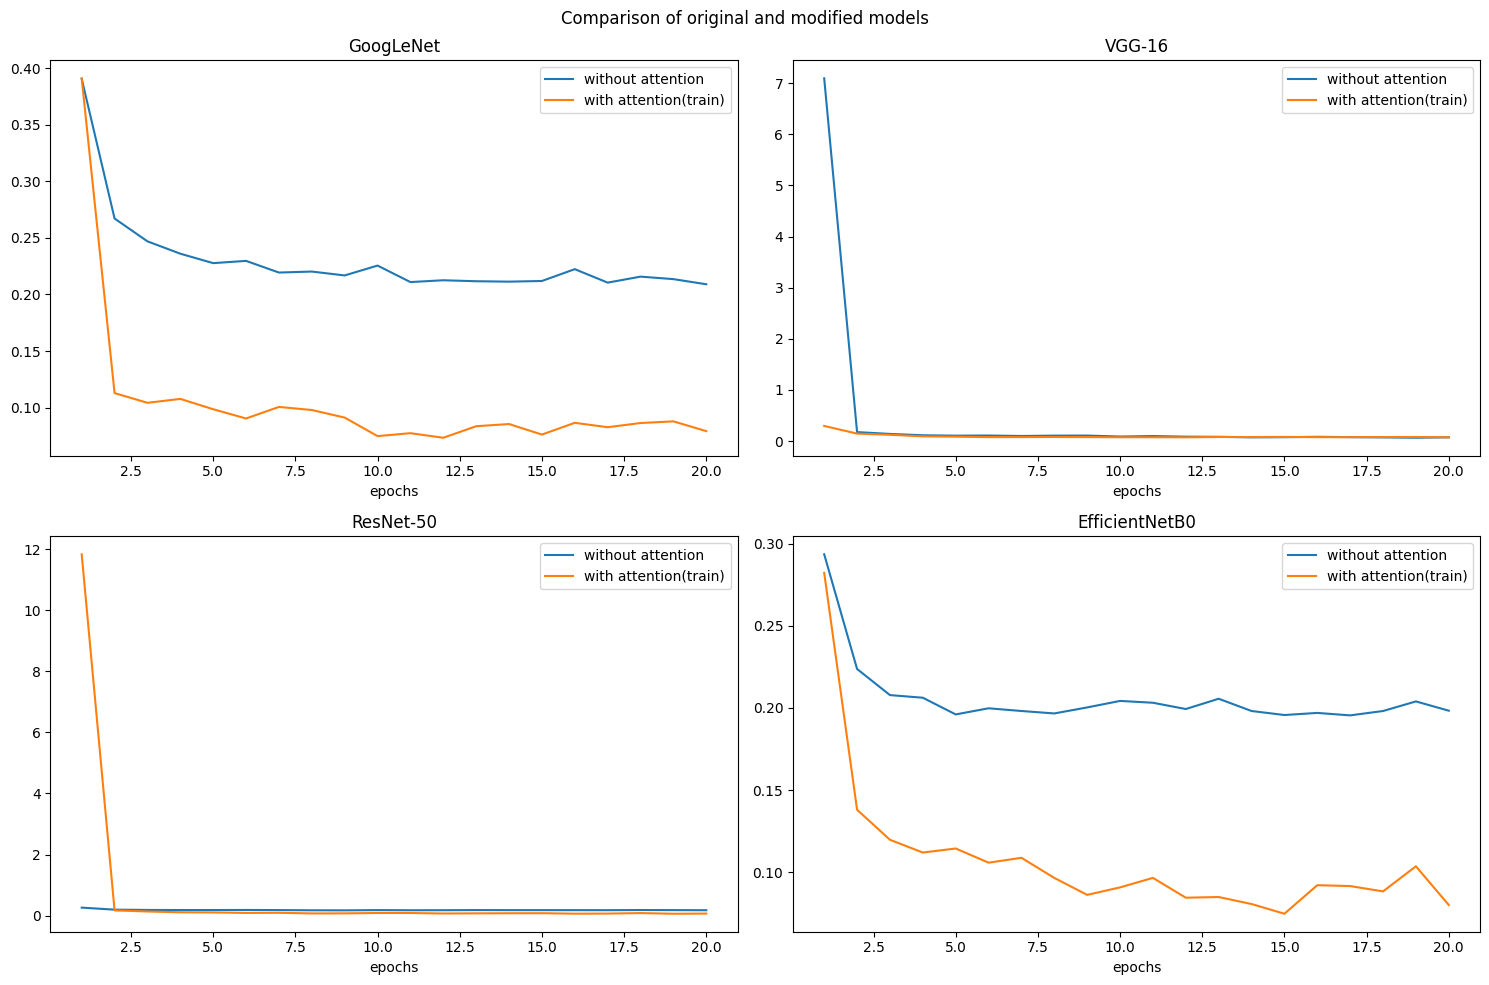

In [ ]:
compare_loss = [google_loss, google_train_loss, vgg_loss, vgg_train_loss, res_loss, res_train_loss, effi_loss, effi_train_loss]
compare_title = ["GoogLeNet", "VGG-16", "ResNet-50", "EfficientNetB0"]
compare_model(compare_loss, compare_title)

## visualize loss function

In [ ]:
def visualize(model_name, loss_acc, title):
  plt.figure(figsize=(15, 4))
  index = 0

  for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax.plot(range(1, epochs+1), loss_acc[index], label="train")
    index += 1
    ax.plot(range(1, epochs+1), loss_acc[index], label="val")
    index += 1
    ax.set_xlabel("epochs")
    ax.set_title(title[i])
    ax.legend()

  plt.suptitle(model_name)
  plt.show()

# since data type of acc is torch.tensor on "cuda"
# we must convert it into float on "cpu"
#def cuda_to_cpu(tensor_list):
#  tensor_to_float = [tensor.cpu().item() for tensor in tensor_list]
#  return tensor_to_float


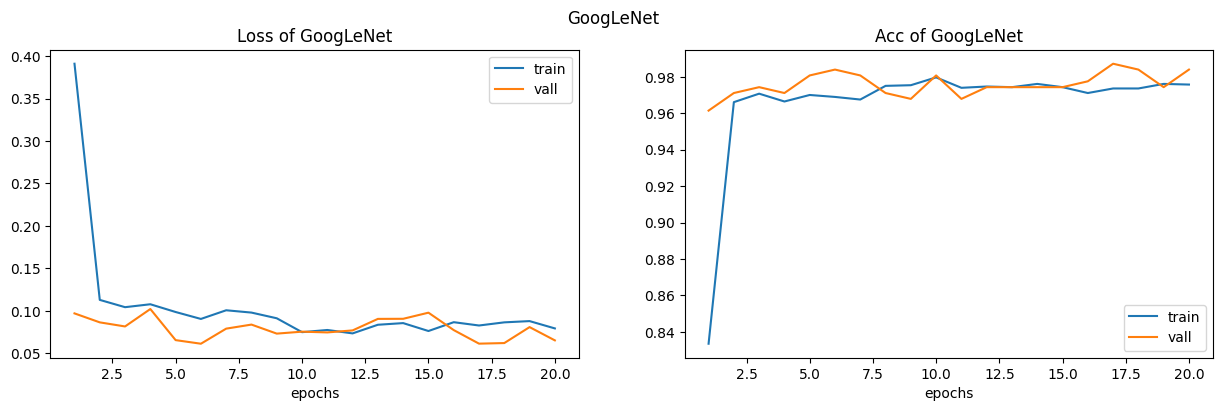

In [ ]:
# googlenet
#google_train_acc = cuda_to_cpu(google_train_acc)
#google_val_acc = cuda_to_cpu(google_val_acc)

loss_acc_google = [google_train_loss, google_val_loss, google_train_acc, google_val_acc]
title_google = ["Loss of GoogLeNet", "Acc of GoogLeNet"]

visualize("GoogLeNet", loss_acc_google, title_google)



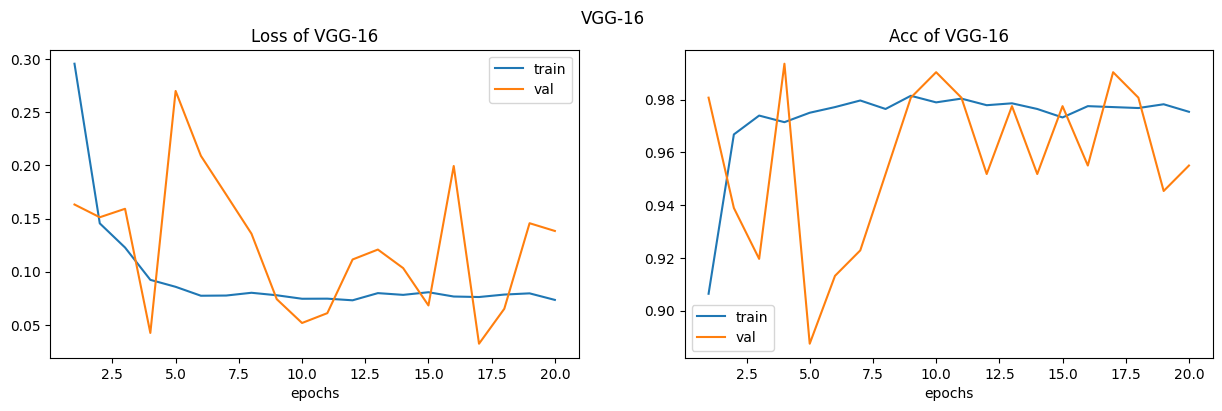

In [ ]:
# vgg-16
#vgg_train_acc = cuda_to_cpu(vgg_train_acc)
#vgg_val_acc = cuda_to_cpu(vgg_val_acc)

loss_acc_vgg = [vgg_train_loss, vgg_val_loss, vgg_train_acc, vgg_val_acc]
title_vgg = ["Loss of VGG-16", "Acc of VGG-16"]

visualize("VGG-16", loss_acc_vgg, title_vgg)



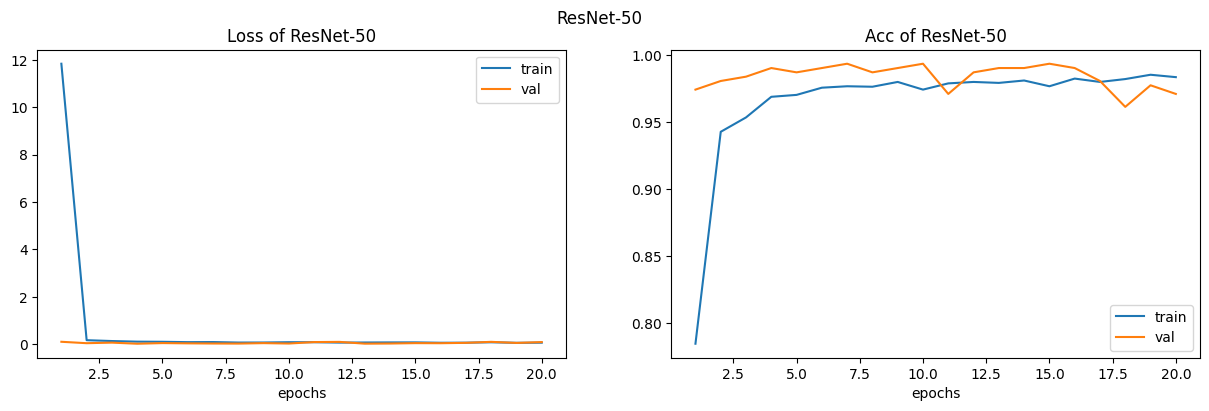

In [ ]:
# resnet
#res_train_acc = cuda_to_cpu(res_train_acc)
#res_val_acc = cuda_to_cpu(res_val_acc)

loss_acc_res = [res_train_loss, res_val_loss, res_train_acc, res_val_acc]
title_res = ["Loss of ResNet-50", "Acc of ResNet-50"]

visualize("ResNet-50", loss_acc_res, title_res)



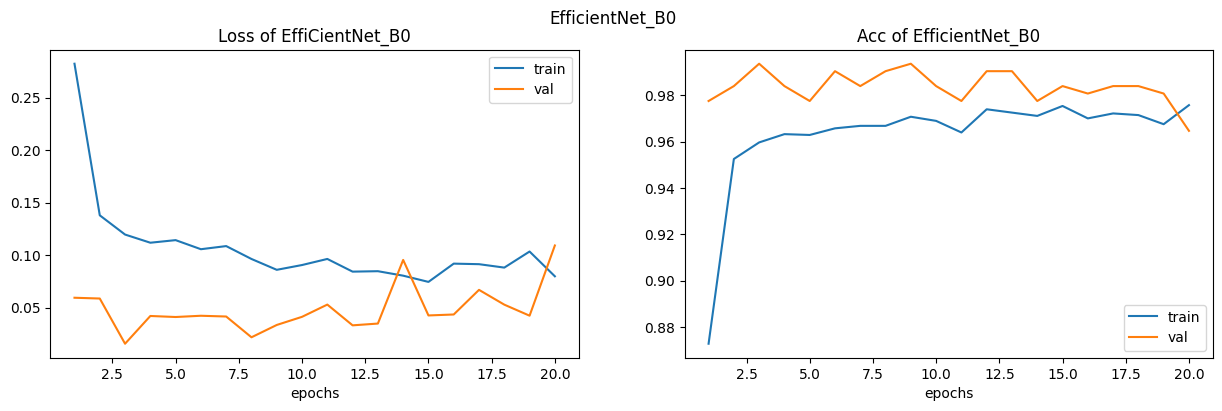

In [ ]:
# efficientnet
#effi_train_acc = cuda_to_cpu(effi_train_acc)
#effi_val_acc = cuda_to_cpu(effi_val_acc)

loss_acc_effi = [effi_train_loss, effi_val_loss, effi_train_acc, effi_val_acc]
title_effi = ["Loss of EffiCientNet_B0", "Acc of EfficientNet_B0"]

visualize("EfficientNet_B0", loss_acc_effi, title_effi)



# Testing

## define testing function

In [ ]:
def test_model(model):
  was_training = model.training
  correct = 0.0
  threshold = torch.tensor(0.5)

  model.eval()
  with torch.no_grad():
    for data, label in test_dl:
      data, label = data.to(device), label.to(device)
      label = label.float()
      label = torch.unsqueeze(label, dim=1)

      output = model(data)

      pred = output > threshold
      correct += torch.sum(pred == label.data)

  acc = correct / len(test_dl.dataset)
  error = len(test_dl.dataset) - correct
  model.train(mode=was_training)

  return acc

In [ ]:
# without attention(還沒訓練)
#google_test_acc = test_model(google)
#vgg_test_acc = test_model(vgg)
#res_test_acc = test_model(res)
#effi_test_acc = test_model(effi)

# with attention
google_atten_test_acc = test_model(google_atten)
vgg_atten_test_acc = test_model(vgg_atten)
res_atten_test_acc = test_model(res_atten)
effi_atten_test_acc = test_model(effi_atten)

In [ ]:
#print(f"Acc for GoogLeNet without attention: {google_test_acc:.5f}")
print(f"Acc for GoogLeNet with attention: {google_atten_test_acc[0]:.5f}")
print()

#print(f"Acc for VGG-16 without attention: {vgg_test_acc:.5f}")
print(f"Acc for VGG-16 with attention: {vgg_atten_test_acc:.5f}")
print()

#print(f"Acc for ResNet-50 without attention: {res_test_acc:.5f}")
print(f"Acc for ResNet-50 with attention: {res_atten_test_acc:.5f}")
print()

#print(f"Acc for EfficientNet_B0 without attention: {effi_test_acc:.5f}")
print(f"Acc for EfficientNet_B0 with attention: {effi_atten_test_acc:.5f}")

Acc for GoogLeNet with attention: 0.98329

Acc for VGG-16 with attention: 0.98458

Acc for ResNet-50 with attention: 0.98072

Acc for EfficientNet_B0 with attention: 0.97429


## test another model

In [ ]:
def test_another(model):
  was_training = model.training # save current mode
  acc = 0.0
  correct = 0

  model.eval()
  with torch.no_grad():
    for data, label in test_dl:
      data, label = data.to(device), label.to(device)

      output = model(data)
      _, pred = torch.max(output, 1)
      correct += torch.sum(pred == label.data)

  acc = correct.float() / len(test_dl.dataset)
  model.train(mode=was_training) # back to previous mode

  return acc

In [ ]:
# test another paper model
path_res = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(1)/Res-50_mod_model.pt"
path_vgg = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(1)/VGG-16_mod_model.pt"
model_res = torch.load(path_res)
model_vgg = torch.load(path_vgg)

another_acc_res = test_another(model_res)
another_acc_vgg = test_another(model_vgg)

print(f"Acc for implement(1) model(ResNet): {another_acc_res:.5f}")
print(f"Acc for implement(1) model(VGG): {another_acc_vgg:.5f}")

Acc for implement(1) model(ResNet): 0.98072
Acc for implement(1) model(VGG): 0.91517


## save model

In [ ]:
def save_model(model, filename_model, filename_param, path):
  model_path = path + filename_model
  param_path = path + filename_param
  torch.save(model, model_path)        # save all model
  torch.save(model.state_dict(), param_path)  # save parameters

In [ ]:
save_root = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/"

# save original model(還沒訓練)
#save_model(google, "google_model.pt", "google_param.pth", save_root) # save googlenet and its param
#save_model(vgg, "vgg_model.pt", "vgg_param.pth", save_root)      # save vgg and its param
#save_model(res, "res_model.pt", "res_param.pth", save_root)      # save resnet and its param
#save_model(effi, "effi_model.pt", "effi_param.pth", save_root)    # save efficientnet and its param

# save modified model
save_model(google_atten, "google_atten_model.pt", "google_atten_param.pth", save_root) # save googlenet and its param
save_model(vgg_atten, "vgg_atten_model.pt", "vgg_atten_param.pth", save_root)      # save vgg and its param
save_model(res_atten, "res_atten_model.pt", "res_atten_param.pth", save_root)      # save resnet and its param
save_model(effi_atten, "effi_atten_model.pt", "effi_atten_param.pth", save_root)    # save efficientnet and its param


# Grad-CAM

In [ ]:
from PIL import Image

## load data

In [ ]:
from torchvision import transforms
path_data_fire = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(2)/fire_ds/test/1_fire/fire_1592.jpg"
path_data_fire2 = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(2)/fire_ds/test/1_fire/fire_1621.jpg"
path_data_nonfire = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(2)/fire_ds/test/0_neutral/neutral_1833.jpg"
path_data_nonfire2 = "/content/drive/MyDrive/Colab Notebooks/graduates class/Application of Structure Machine Learning/implement_(2)/fire_ds/test/0_neutral/neutral_1792.jpg"


transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

img_fire = Image.open(path_data_fire)
img_fire2 = Image.open(path_data_fire2)
img_nonfire = Image.open(path_data_nonfire)
img_nonfire2 = Image.open(path_data_nonfire2)

img_fire_tensor = transforms(img_fire)
img_fire_tensor = torch.unsqueeze(img_fire_tensor, dim=0)     # [1, 3, 224, 224]

img_fire_tensor2 = transforms(img_fire2)
img_fire_tensor2 = torch.unsqueeze(img_fire_tensor2, dim=0)     # [1, 3, 224, 224]

img_nonfire_tensor = transforms(img_nonfire)
img_nonfire_tensor = torch.unsqueeze(img_nonfire_tensor, dim=0)  # [1, 3, 224, 224]

img_nonfire_tensor2 = transforms(img_nonfire2)
img_nonfire_tensor2 = torch.unsqueeze(img_nonfire_tensor2, dim=0)  # [1, 3, 224, 224]

## model

In [ ]:
for name, layer in effi_atten.named_children():
  print(name)

features
gap
classifier


## Grad-CAM

In [ ]:
class GradCAM():
    def __init__(self, model):
        self.Sigmoid = nn.Sigmoid()
        self.model = model
        self.features = model.features
        self.gap = model.gap
        self.classifier = model.classifier

    def _predict(self, img_tensor): # predict logits and probability
        with torch.no_grad():
            logits = self.model(img_tensor) # size = [batch=1, n_classes=1]
            probas = self.Sigmoid(logits)   # size = [batch=1, n_classes=1]

        self.probas = probas.detach().numpy().squeeze() # shape = [n_classes=1]
        #print(f"aaa {self.probas.shape}") # debud

    def _save_gradient(self, grad):
        self.gradient = grad.detach().numpy()[0] # escape gradient descent, convert into numpy, take[C, H, W]

    def _forward(self, img_tensor):
        feature_maps = self.features(img_tensor)
        gap = self.gap(feature_maps)
        logits = self.classifier(gap)

        feature_maps.register_hook(self._save_gradient) # use feature_map to register a hook

        self.output = logits

        self.feature_maps = feature_maps.detach().numpy().squeeze() # (C, H, W)

    def _backward(self, class_idx):
        #onehot_target = torch.zeros(self.probas.shape, dtype=torch.float)
        #onehot_target = torch.unsqueeze(onehot_target, dim=0) # [batch=1, n_classes]
        #onehot_target[0][class_idx] = 1
        onehot_target = torch.tensor(1.)

        self.model.zero_grad()
        #self.output.backward(gradient=onehot_target)
        self.output.backward()

    def _get_class_idx(self, i):
        class_idx = self.probas.argsort() # return index from small prob to high prob
        class_idx = class_idx[-i]         # converse index
        return class_idx

    def generate_heatmap(self, img_tensor, class_idx):
        self.input_size = list(img_tensor.size())[2:] # [batch, C, H, W] -> [H, W]
        self._forward(img_tensor)
        self._backward(class_idx)

        weights = np.mean(self.gradient, axis=(1, 2)) # global average pooling
                                                      # since, selg.gradient is array, can't use torch
        weights = weights.reshape((-1, 1, 1))

        heatmap = np.sum(weights * self.feature_maps, axis=0) # multiplicate weight and sum
        heatmap = np.maximum(heatmap, 0)                      # ReLU
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8) # Normalize between 0 to 1
        heatmap = np.uint8(heatmap*255)                      # convert uint-8 and mapping to 0-255
        heatmap = Image.fromarray(heatmap)                   # convert from array to PIL
        heatmap = heatmap.resize(self.input_size, Image.ANTIALIAS)  # resize to original size and interpolation
        heatmap = np.array(heatmap)                          # convert to array to plot by matplotlib

        return heatmap

    def plot_heatmap(self, img, img_tensor, top=1):
        self.input_size = list(img_tensor.size())[2:]
        self._predict(img_tensor) # obtain self.probas

        cols = top + 1
        plt.figure(figsize=(4 * cols, 4))

        for i in range(cols):
            if i == 0:
                plt.subplot(1, cols, i+1)
                plt.imshow(img)
                plt.title("original image")
                plt.axis("off")

            else:
                class_idx = self._get_class_idx(i)
                heatmap = self.generate_heatmap(img_tensor, class_idx)

                plt.subplot(1, cols, i+1)
                plt.imshow(img, alpha=1.0)
                plt.imshow(heatmap, cmap="jet", alpha=0.7)
                plt.title("heatmap")
                plt.axis("off")

#effi_atten_cpu = copy.deepcopy(effi_atten)
#effi_atten_cpu = effi_atten_cpu.to("cpu")

#for param in effi_atten_cpu.features.parameters():
#  param.requires_grad = True

Grad_CAM = GradCAM(effi_atten_cpu)

## heatmap

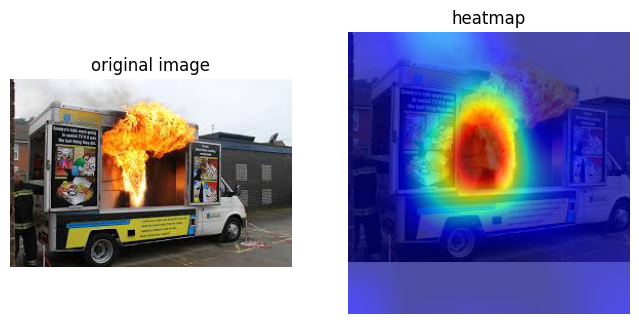

In [ ]:
Grad_CAM.plot_heatmap(img_fire, img_fire_tensor)

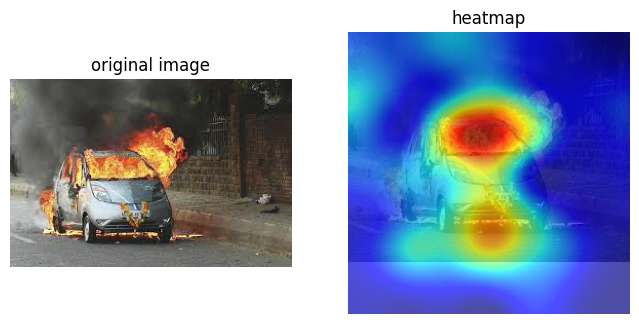

In [ ]:
Grad_CAM.plot_heatmap(img_fire2, img_fire_tensor2)

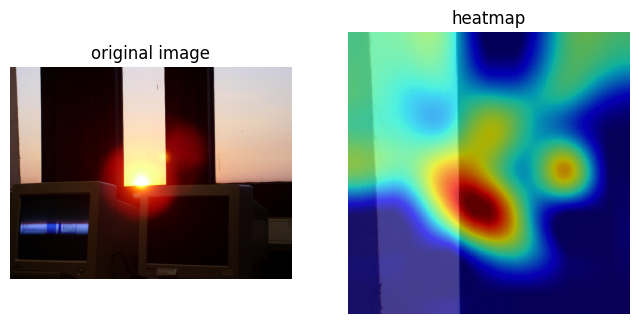

In [ ]:
Grad_CAM.plot_heatmap(img_nonfire, img_nonfire_tensor)

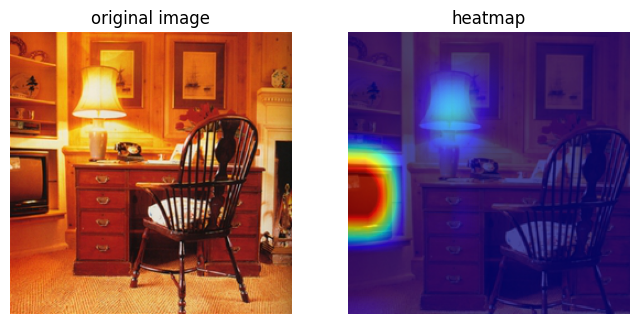

In [ ]:
Grad_CAM.plot_heatmap(img_nonfire2, img_nonfire_tensor2)